# Oil, Gold, NASDAQ, and USD-index dataset

- Oil: Brent daily in USD from https://www.eia.gov/dnav/pet/hist/RBRTEd.htm
- Gold: LMBA gold daily at 10:30AM in USD from https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM
- NASDAQ: adjusted closing price (daily) from https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- USD index: traded weighted on broad currency index from https://fred.stlouisfed.org/series/TWEXB

In [1]:
# ale
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk
import gpflow

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime

%reload_ext autoreload
%autoreload 2


# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)
# plt.rcParams["font.family"] = "Times New Roman"

import mogptk
import numpy as np

%reload_ext autoreload
%autoreload 2

In [2]:
oil = mogptk.LoadCSV('data/gonu/brent-daily.csv',
                     'Date',
                     'Price',
                     name='Oil',
                     format={'Date': mogptk.FormatDate})
gold = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv',
                      'Date',
                      'Price',
                      name='Gold',
                      format={'Date': mogptk.FormatDate})
nasdaq = mogptk.LoadCSV('data/gonu/nasdaq.csv',
                        'Date',
                        'Adj Close',
                        name='NASDAQ',
                        format={'Date': mogptk.FormatDate})
usd = mogptk.LoadCSV('data/gonu/TWEXB.csv',
                     'Date',
                     'Price',
                     name='USD',
                     format={'Date': mogptk.FormatDate})

f_paths = [
    'data/gonu/brent-daily.csv',
    'data/gonu/lmba-gold-usd-am-daily.csv',
    'data/gonu/nasdaq.csv',
    'data/gonu/TWEXB.csv'
          ]
cols = ['Oil', 'Gold', 'NASDAQ', 'USD']

data = [oil, gold, nasdaq, usd]


np.random.seed(1)
for i, channel in enumerate(data):
    channel.filter('2015-01-01', '2018-12-31')
    channel.aggregate('7d')
    
    channel.transform(mogptk.TransformLog)
    channel.transform(mogptk.TransformDetrend)
    
    if i == 0:
        channel.remove_range('2018-10-05', None)
        channel.remove_randomly(pct=0.3)
    if i == 1:
        channel.remove_range('2016-11-15', '2017-01-01')
        channel.remove_randomly(pct=0.6)
    if i == 2:
        # channel.remove_range('2018-10-01', None)
        channel.remove_randomly(pct=0.6)
        # channel.remove_range('2018-10-01', None)
        # channel.remove_range('2016-01-01', '2016-03-01')
        
    if i == 3:
        channel.remove_range('2016-03-15', '2016-06-01')
        channel.remove_randomly(pct=0.6)
        
    # channel.plot()
    
# for i, channel in enumerate(data):
    # channel.plot_spectrum(per='day')    
    # print('BNSE:', channel.get_bnse_estimation())
    # print('LombScargle:', channel.get_ls_estimation())
    
# oil.set_pred_range('2015-07-01', '2018-07-01', n=1000)
# gold.set_pred_range('2015-07-01', '2018-07-01', n=1000)
# nasdaq.set_pred_range('2015-07-01', '2018-07-01', n=1000)
# usd.set_pred_range('2015-07-01', '2018-07-01', n=1000)

x_test = [channel.X[~channel.mask] for channel in data]
y_test = [mogptk.data._detransform(c.transformations, c.X, c.Y)[~c.mask] for c in data]

## MOSM

In [3]:
%%time
n_trials = 5

mosm_list = []
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_mape = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=3)
    model_mosm.init_params('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    
    print('='*50)
    
    mosm_list.append(model_mosm)
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_mape[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    print('Finished trial', n)

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -936.794688
  Number of iterations: 5000
  Number of functions evaluations: 5584
Done in  4.486439883708954  minutes
Finished trial 0
Starting trial 1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -939.915961
  Number of iterations: 5000
  Number of functions evaluations: 5513
Done in  4.485040601094564  minutes
Finished trial 1
Starting trial 2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -938.041724
  Number of iterations: 5000
  Number of functions evaluations: 5485
Done in  4.448557341098786  minutes
Finished trial 2
Starting trial 3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -9

In [4]:
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,1.947926,3.487693,2.724266,0.269925,0.474905,0.624287
1,15.469917,1.267165,20.850556,1.011435,0.086256,1.067365
2,117.387599,1.873060,165.001098,3.048099,0.047127,9.774961
3,0.744726,0.616038,0.993098,0.062504,0.051838,0.107387


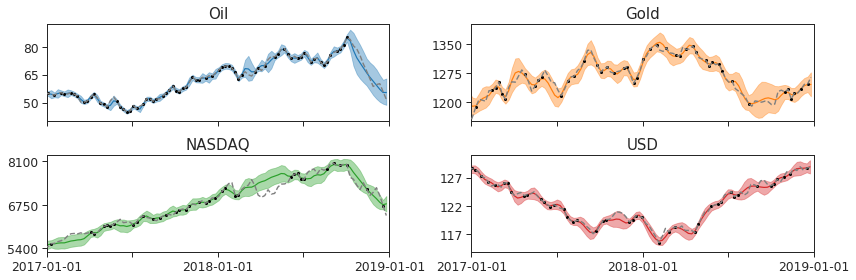

In [22]:
best_mosm = mosm_list[np.argmin(mosm_mape.mean(1))]
ylims = [(40, 92), (1150, 1400), (5300, 8300), (114, 131)]
f, axarr = mogptk.plot_prediction(best_mosm,
                       grid=(2, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 4));

yticks = [(50, 80), (1200, 1350), (5400, 8100), (117, 127)]

for i in range(len(cols)):
    axarr[i].set_title(cols[i], fontsize=15)
    axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))

    channel = best_mosm.data[i]

    xlabels = pd.date_range('2015-01-01', '2018-12-31', periods=9).date
    xticks = [channel.formatters[0]._parse(str(label)) for label in xlabels]
    
    new_xlabels = ['']*9
    xlabels[::2][2:] += datetime.timedelta(days=1)
    new_xlabels[::2] = xlabels[::2]
    
    axarr[i].set_xticks(xticks)
    axarr[i].set_xticklabels(new_xlabels)
    axarr[i].set_xlim(xticks[4], xticks[-1])

plt.tight_layout()
    
plt.savefig('output/mosm_gonu.pdf', bbox_inches='tight')

In [33]:
cross_params = best_mosm.get_cross_params()
cross_params['delay'][:, :, 0, 2]

array([[ 0.        , -1.40622884, -0.50614942,  1.61493746],
       [ 1.40622884,  0.        ,  0.90007943,  3.0211663 ],
       [ 0.50614942, -0.90007943,  0.        ,  2.12108688],
       [-1.61493746, -3.0211663 , -2.12108688,  0.        ]])

mosm = mogptk.MOSM(data, Q=3)
mosm.init_params()

mosm.train(tol=1e-6, maxiter=2000)
mosm.plot()
mosm.print()
mosm.info()

mosm.predict()
mosm.plot_data()

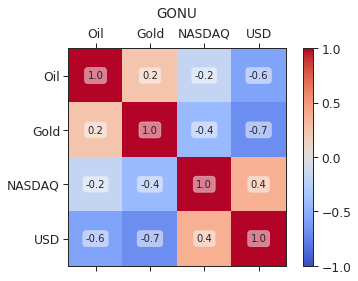

In [11]:
f, ax, corr_matrix = best_mosm.plot_correlations()
ax.set_title('GONU', pad=20)
ax.set_yticks(np.arange(4));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(4));
ax.set_xticklabels(cols);
plt.savefig('output/corr_gonu_best.pdf', bbox_inches='tight')

In [95]:
y_all = [mogptk.data._detransform(c.transformations, c.X, c.Y) for c in best_mosm.data]
y_all_array = np.empty((207, 0))
for y in y_all:
    y_all_array = np.c_[y_all_array, y[:207]]

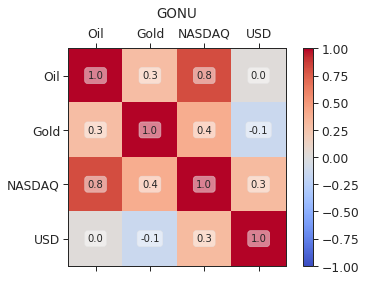

In [99]:
auto_corr = np.corrcoef(y_all_array.T)

color_range = np.abs(auto_corr).max()

f, ax = plt.subplots()
im = ax.matshow(auto_corr, cmap='coolwarm', vmin=-color_range, vmax=color_range)

ax.set_title('GONU', pad=20)
f.colorbar(im)
for (i, j), z in np.ndenumerate(auto_corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))

ax.set_yticks(np.arange(4));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(4));
ax.set_xticklabels(cols);

plt.savefig('output/autocorr_gonu.pdf', bbox_inches='tight')

In [63]:
y_all_array.shape

(208, 4)

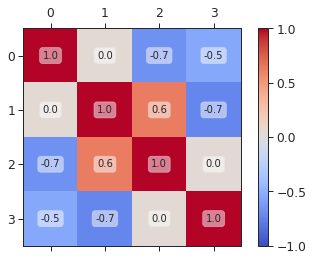

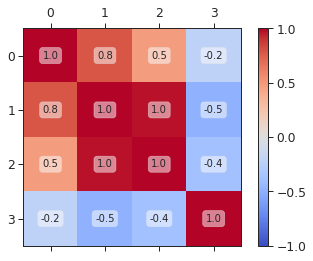

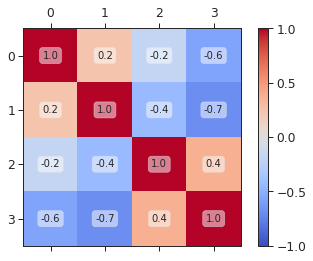

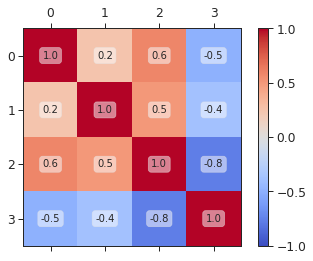

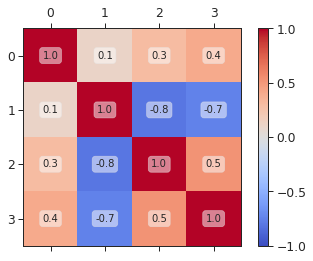

In [100]:
corr_list = []

for model in mosm_list:
    _, _, corr = model.plot_correlations();
    corr_list.append(corr)

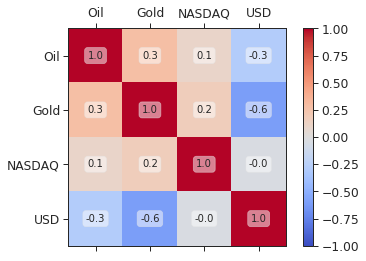

In [102]:
corr_array = np.array(corr_list)
color_range = np.abs(corr_array.mean(0)).max()

f, ax = plt.subplots()
im = ax.matshow(corr_array.mean(0), cmap='coolwarm', vmin=-color_range, vmax=color_range)
f.colorbar(im)
for (i, j), z in np.ndenumerate(corr_array.mean(0)):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.9'))

ax.set_yticks(np.arange(4));
ax.set_yticklabels(cols);
ax.set_xticks(np.arange(4));
ax.set_xticklabels(cols);
plt.savefig('output/corr_gonu_mean.pdf', bbox_inches='tight')

In [ ]:
best_mosm.params

## MOSM-Student-T like

In [ ]:
like = gpflow.likelihoods.StudentT

In [ ]:
%%time
n_trials = 1
like_params = {'scale':1e-3, 'df':3}

mosm_student_list = []
mosm_student_mae = np.zeros((n_trials, len(cols)))
mosm_student_mape = np.zeros((n_trials, len(cols)))
mosm_student_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    mosm_student = mogptk.MOSM(data, Q=4)
#    model_mosm.init_params('BNSE')
    mosm_student.params = best_model.params
    
    print('Starting trial', n)
    # mosm_student.build(likelihood=like, like_params=like_params, variational=False)
    mosm_student.train(method='L-BFGS-B', maxiter=5000, tol=1e-50, likelihood=like, like_params=like_params, variational=True)
    
    print('='*50)
    
    mosm_student_list.append(mosm_student)
    
    # errors per channel
    error = mogptk.test_errors(mosm_student, x_test=x_test, y_test=y_test)
    
    mosm_student_mae[n, :] = np.array(error[0])[:, 0]
    mosm_student_mape[n, :] = np.array(error[0])[:, 1]
    mosm_student_rmse[n, :] = np.array(error[0])[:, 2]
    print('Finished trial', n)

In [ ]:
pd.DataFrame(np.c_[mosm_student_mae.mean(0), mosm_student_mape.mean(0), mosm_student_rmse.mean(0),
                             mosm_student_mae.std(0), mosm_student_mape.std(0), mosm_student_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

In [ ]:
mosm_mape.mean(), mosm_student_mape.mean()

In [ ]:
mosm_student.likelihood.scale

In [ ]:
best_student = mosm_student_list[np.argmin(mosm_student_mape.mean(1))]
ylims = [(20, 100), (1000, 1500), (4000, 8600), (110, 135)]
f, axarr = mogptk.plot_prediction(best_student,
                       grid=(2, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 4));

yticks = [(30, 90), (1100, 1400), (4500, 8000), (114, 130)]

for i in range(len(cols)):
    axarr[i].set_title(cols[i], fontsize=13)
    axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))

    channel = best_student.data[i]

    xlabels = pd.date_range('2015-01-01', '2018-12-31', periods=9).date
    xticks = [channel.formatters[0]._parse(str(label)) for label in xlabels]
    
    new_xlabels = ['']*9
    xlabels[::2][2:] += datetime.timedelta(days=1)
    new_xlabels[::2] = xlabels[::2]
    
    axarr[i].set_xticks(xticks)
    axarr[i].set_xticklabels(new_xlabels)

plt.tight_layout()

In [ ]:
import pickle

with open('output/best_mosm_gonu.p', 'wb') as fp:
    pickle.dump(best_mosm.params, fp, protocol=pickle.HIGHEST_PROTOCOL)

## CSM

In [ ]:
%%time
n_trials = 5

csm_mae = np.zeros((n_trials, len(cols)))
csm_mape = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))
csm_list = []

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=3)
    model_csm.init_params('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=5000, tol=1e-15)
    print('Finished trial', n)
    print('='*50)
    csm_list.append(model_csm)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_mape[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]

In [ ]:
pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

In [ ]:
best_csm = csm_list[np.argmin(csm_mape.mean(1))]
mogptk.plot_prediction(model_csm,grid=(2, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 4));

csm = mogptk.CSM(data, Q=3)
csm.init_params()
csm.train(tol=1e-6, maxiter=2000)
csm.print()

csm.predict()
csm.plot_data()

## SM-LMC

In [ ]:
%%time
n_trials = 5

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_mape = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=3)
    model_smlmc.init_params('BNSE')
    print('='*50)
    
    model_smlmc.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_mape[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]

In [ ]:
pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'MAPE%', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

In [ ]:
mogptk.plot_prediction(model_smlmc,grid=(2, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 4));

smlmc = mogptk.SM_LMC(data, Q=3)
smlmc.init_params()
smlmc.train(tol=1e-6, maxiter=2000)
smlmc.print()

smlmc.predict()
smlmc.plot_data()

# IGP
Independent GP with SM kernels

In [26]:
%%time
n_trials = 5

igp_mae = np.zeros((n_trials, len(cols)))
igp_mape = np.zeros((n_trials, len(cols)))
igp_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    
    igp_list = []
    
    for i in range(len(cols)):
        model_sm = mogptk.SM(data[i], Q=3)
        model_sm.init_params('BNSE')
        model_sm.train(method='L-BFGS-B', maxiter=5000, tol=1e-50)
        
        igp_list.append(model_sm)
        
        error = mogptk.test_errors(model_sm, x_test=[x_test[i]], y_test=[y_test[i]])
    
        igp_mae[n, i] = np.array(error[0])[:, 0]
        igp_mape[n, i] = np.array(error[0])[:, 1]
        igp_rmse[n, i] = np.array(error[0])[:, 2]
    print('='*50)
    

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -209.945633
  Number of iterations: 81
  Number of functions evaluations: 138
Done in  0.01652000347773234  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -196.702987
  Number of iterations: 69
  Number of functions evaluations: 120
Done in  0.013223417599995931  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -185.733800
  Number of iterations: 54
  Number of functions evaluations: 117
Done in  0.011216994126637776  minutes
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -244.523049
  Number of iterations: 67
  Number of functions evaluations: 99
Done in  0.011169147491455079  minute

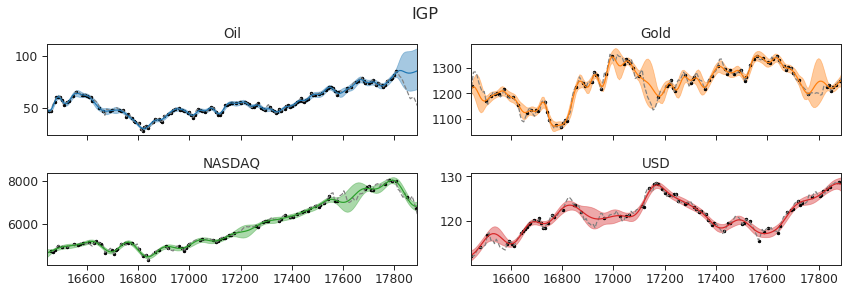

In [44]:
f, axarr = plt.subplots(2, 2, sharex=True, figsize=(12, 4))
axarr = axarr.reshape(-1)

for i in range(len(cols)):
    c = igp_list[i].data[0]
    x_train = c.X[c.mask]
    y_train = mogptk.data._detransform(c.transformations, c.X[c.mask], c.Y[c.mask])
    
    x_all = c.X
    y_all = mogptk.data._detransform(c.transformations, c.X, c.Y)
    
    x_pred = c.X
    mean_pred, lower_ci, upper_ci = igp_list[i].predict([x_pred])
    
    axarr[i].plot(x_train[:, 0], y_train, '.k', label='Train', )
    axarr[i].plot(x_all[:, 0], y_all, '--', label='Test', c='gray')

    axarr[i].plot(x_pred[:, 0], mean_pred[0], label='Post.Mean', c=sns.color_palette()[i%10])
    axarr[i].fill_between(x_pred[:, 0].reshape(-1),
                          lower_ci[0],
                          upper_ci[0],
                          label='95% c.i',
                          color=sns.color_palette()[i%10],
                          alpha=0.4)

    # axarr[i].legend(ncol=4, loc='upper center', fontsize=8)
    axarr[i].set_xlim(x_all[0]-1, x_all[-1])

    # set channels name
    
    axarr[i].set_title(cols[i])

plt.suptitle('IGP', y=1.02)
plt.tight_layout()

## Results

In [27]:
igp_mape[:, :].mean()

2.773855778714582

In [28]:
igp_mape.std()

2.657399899451433

In [24]:
print(mosm_mape[:, :].mean(), csm_mape[:, :].mean(), smlmc_mape[:, :].mean(), igp_mape[:, :].mean())

NameError: name 'csm_mape' is not defined

In [ ]:
print(mosm_mape[:, :].std(), csm_mape[:, :].std(), smlmc_mape[:, :].std(), igp_mape[:, :].std())